# Yahoo Finance API - Cryptocurrency Returns Analysis (Jan 2020 - Present)
# =================================================================

In [1]:
# Cell 1: Import required libraries
#================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import json
import os
import http.client
from IPython.display import display, HTML
import boto3
from botocore.exceptions import ClientError
from snowflake.snowpark.secrets import Secret



In [2]:
# Set Jupyter display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
sns.set_palette('Set2')

In [3]:
# RapidAPI configuration
RAPIDAPI_KEY = Secret.get("CRYPTO_API_SECRET").password
# Replace with your actual RapidAPI key
RAPIDAPI_HOST = "apidojo-yahoo-finance-v1.p.rapidapi.com"

In [4]:
# Cryptocurrency symbols (with Yahoo Finance suffix for crypto)
CRYPTO_SYMBOLS = {
    "BTC": "BTC-USD",
    "ETH": "ETH-USD", 
    "DOGE": "DOGE-USD"
}

In [5]:
# Time range (January 1, 2020 to current date)
START_DATE = datetime(2020, 1, 1)
END_DATE = datetime.now()

print(f"Data range: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print(f"API Host: {RAPIDAPI_HOST}")
print(f"Cryptocurrencies: {', '.join(CRYPTO_SYMBOLS.keys())}")

Data range: 2020-01-01 to 2025-02-25
API Host: apidojo-yahoo-finance-v1.p.rapidapi.com
Cryptocurrencies: BTC, ETH, DOGE


In [6]:
# Create directories for output
os.makedirs('data', exist_ok=True)
os.makedirs('raw_responses', exist_ok=True)

In [7]:
# Functions for API data fetching
def get_historical_data(symbol, interval="1d", range_period="5y"):
    """
    Fetches historical price data for a cryptocurrency from Yahoo Finance via RapidAPI.
    
    Parameters:
    - symbol: The Yahoo Finance symbol for the cryptocurrency
    - interval: Time interval between data points (1d for daily, 1mo for monthly)
    - range_period: How far back to get data (5y = 5 years)
    
    Returns:
    - DataFrame with historical price data
    - None if there was an error
    """
    try:
        print(f"Fetching {interval} data for {symbol} over {range_period}...")
        
        # Create connection to RapidAPI Yahoo Finance endpoint
        conn = http.client.HTTPSConnection("yh-finance.p.rapidapi.com")
        
        # Set headers with API key
        headers = {
            'X-RapidAPI-Key': RAPIDAPI_KEY,
            'X-RapidAPI-Host': RAPIDAPI_HOST
        }
        
        # Build the API endpoint with query parameters
        endpoint = f"/stock/v3/get-chart?interval={interval}&symbol={symbol}&range={range_period}"
        endpoint += "&includePrePost=false&useYfid=true&includeAdjustedClose=true&events=capitalGain,div,split"
        
        # Make the request
        print(f"Requesting: {endpoint}")
        conn.request("GET", endpoint, headers=headers)
        
        # Get the response
        res = conn.getresponse()
        
        # Check if response is successful
        if res.status != 200:
            print(f"Error: Received status code {res.status} for {symbol}")
            print(f"Response: {res.read().decode('utf-8')}")
            return None
        
        # Read and parse the response
        data_bytes = res.read()
        
        # Save raw response for debugging (optional)
        os.makedirs('raw_responses', exist_ok=True)
        with open(f"raw_responses/{symbol}_{interval}_{range_period}.json", 'w') as f:
            json.dump(json.loads(data_bytes.decode('utf-8')), f, indent=2)
            
        # Parse the JSON data
        data = json.loads(data_bytes.decode('utf-8'))
        
        # Check for errors in the response
        if 'chart' in data and data['chart'].get('error'):
            print(f"API returned an error for {symbol}: {data['chart']['error']}")
            return None
            
        # Extract the relevant data from the response
        if 'chart' in data and 'result' in data['chart'] and len(data['chart']['result']) > 0:
            result = data['chart']['result'][0]
            
            # Get timestamps and convert to datetime
            timestamps = result.get('timestamp', [])
            if not timestamps:
                print(f"No timestamp data found for {symbol}")
                return None
                
            datetime_index = [datetime.fromtimestamp(ts) for ts in timestamps]
            
            # Extract metadata
            meta = result.get('meta', {})
            currency = meta.get('currency', 'USD')
            
            # Extract price data
            indicators = result.get('indicators', {})
            quotes = indicators.get('quote', [{}])[0]
            adjclose = indicators.get('adjclose', [{}])[0].get('adjclose', [])
            
            # Create DataFrame
            df_data = {
                'date': datetime_index,
                'open': quotes.get('open', []),
                'high': quotes.get('high', []),
                'low': quotes.get('low', []),
                'close': quotes.get('close', []),
                'volume': quotes.get('volume', [])
            }
            
            # Add adjusted close if available
            if adjclose:
                df_data['adjclose'] = adjclose
            
            # Create DataFrame
            df = pd.DataFrame(df_data)
            
            # Clean up any NaN values that might be in the data
            df = df.dropna(subset=['close'])
            
            # Set date as index
            df['date'] = pd.to_datetime(df['date'])
            df = df.set_index('date')
            
            # Calculate returns
            if interval == "1d":
                df['daily_return'] = df['close'].pct_change() * 100
            elif interval == "1mo":
                df['monthly_return'] = df['close'].pct_change() * 100
            
            print(f"Successfully retrieved {len(df)} data points for {symbol}")
            
            # Filter to data from Jan 2020 onwards
            filtered_df = df[df.index >= START_DATE]
            print(f"After filtering to {START_DATE.strftime('%Y-%m-%d')} onwards: {len(filtered_df)} data points")
            
            return filtered_df
        else:
            print(f"No data found for {symbol}")
            return None
            
    except Exception as e:
        print(f"Unexpected error processing data for {symbol}: {e}")
        return None

In [8]:
# Calculate monthly returns
def calculate_monthly_returns(daily_df):
    """
    Calculate monthly returns from daily data
    
    Parameters:
    - daily_df: DataFrame with daily price data
    
    Returns:
    - DataFrame with monthly returns
    """
    if daily_df is None or daily_df.empty:
        return None
        
    # Resample to get month-end prices
    monthly_df = daily_df['close'].resample('M').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_df.pct_change() * 100
    
    # Create a DataFrame with the monthly returns
    monthly_returns_df = pd.DataFrame({
        'monthly_return': monthly_returns
    })
    
    return monthly_returns_df

In [9]:
# Save DataFrame to CSV
def save_to_csv(df, crypto_name, return_type):
    """
    Save DataFrame to CSV file
    
    Parameters:
    - df: DataFrame to save
    - crypto_name: Name of the cryptocurrency
    - return_type: 'daily' or 'monthly'
    
    Returns:
    - Filename where data was saved
    """
    if df is None or df.empty:
        print(f"No data to save for {crypto_name} {return_type} returns")
        return None
    
    # Format filename
    filename = f"data/{crypto_name}_{return_type}_returns.csv"
    
    # Reset index to make date a column
    df_to_save = df.reset_index()
    
    # For daily returns, only keep date and return columns
    if return_type == 'daily':
        df_to_save = df_to_save[['date', 'daily_return']]
    else:  # monthly
        df_to_save = df_to_save[['date', 'monthly_return']]
    
    # Save to CSV
    df_to_save.to_csv(filename, index=False)
    print(f"Saved {return_type} returns for {crypto_name} to {filename}")
    return filename

In [10]:
# Save raw data to CSV
def save_raw_data_to_csv(df, crypto_name, interval):
    """
    Save raw price data to CSV file
    
    Parameters:
    - df: DataFrame with price data to save
    - crypto_name: Name of the cryptocurrency
    - interval: Data interval ('daily' or 'monthly')
    
    Returns:
    - Filename where data was saved
    """
    if df is None or df.empty:
        print(f"No raw data to save for {crypto_name} {interval}")
        return None
    
    # Format filename
    filename = f"data/{crypto_name}_raw_{interval}.csv"
    
    # Reset index to make date a column
    df_to_save = df.reset_index()
    
    # Keep all price columns
    columns_to_keep = ['date', 'open', 'high', 'low', 'close', 'volume']
    if 'adjclose' in df_to_save.columns:
        columns_to_keep.append('adjclose')
        
    df_to_save = df_to_save[columns_to_keep]
    
    # Save to CSV
    df_to_save.to_csv(filename, index=False)
    print(f"Saved raw {interval} data for {crypto_name} to {filename}")
    return filename

In [11]:
# Create a dictionary to store our DataFrames
crypto_daily_data = {}

for crypto_name, symbol in CRYPTO_SYMBOLS.items():
    print(f"\nProcessing daily data for {crypto_name} ({symbol})...")
    daily_data = get_historical_data(symbol, interval="1d", range_period="5y")
    
    if daily_data is not None:
        crypto_daily_data[crypto_name] = daily_data
        
        # Save raw daily data
        save_raw_data_to_csv(daily_data, crypto_name, 'daily')
        
        # Save daily returns
        save_to_csv(daily_data, crypto_name, 'daily')
    
    # Pause between API calls to avoid rate limiting
    time.sleep(2)


Processing daily data for BTC (BTC-USD)...
Fetching 1d data for BTC-USD over 5y...
Requesting: /stock/v3/get-chart?interval=1d&symbol=BTC-USD&range=5y&includePrePost=false&useYfid=true&includeAdjustedClose=true&events=capitalGain,div,split
Successfully retrieved 1827 data points for BTC-USD
After filtering to 2020-01-01 onwards: 1827 data points
Saved raw daily data for BTC to data/BTC_raw_daily.csv
Saved daily returns for BTC to data/BTC_daily_returns.csv

Processing daily data for ETH (ETH-USD)...
Fetching 1d data for ETH-USD over 5y...
Requesting: /stock/v3/get-chart?interval=1d&symbol=ETH-USD&range=5y&includePrePost=false&useYfid=true&includeAdjustedClose=true&events=capitalGain,div,split
Successfully retrieved 1827 data points for ETH-USD
After filtering to 2020-01-01 onwards: 1827 data points
Saved raw daily data for ETH to data/ETH_raw_daily.csv
Saved daily returns for ETH to data/ETH_daily_returns.csv

Processing daily data for DOGE (DOGE-USD)...
Fetching 1d data for DOGE-USD 

In [12]:
# Calculate Monthly Returns from Daily Data
# ===============================================
crypto_monthly_data = {}

for crypto_name, daily_data in crypto_daily_data.items():
    print(f"\nCalculating monthly returns for {crypto_name} from daily data...")
    monthly_returns = calculate_monthly_returns(daily_data)
    
    if monthly_returns is not None:
        crypto_monthly_data[crypto_name] = monthly_returns
        
        # Save monthly returns
        save_to_csv(monthly_returns, crypto_name, 'monthly')



Calculating monthly returns for BTC from daily data...
Saved monthly returns for BTC to data/BTC_monthly_returns.csv

Calculating monthly returns for ETH from daily data...
Saved monthly returns for ETH to data/ETH_monthly_returns.csv

Calculating monthly returns for DOGE from daily data...
Saved monthly returns for DOGE to data/DOGE_monthly_returns.csv


In [13]:
# Fetch Monthly Data Directly (Alternative Approach)
# =======================================================
crypto_monthly_direct = {}

for crypto_name, symbol in CRYPTO_SYMBOLS.items():
    print(f"\nFetching monthly data directly for {crypto_name} ({symbol})...")
    monthly_data = get_historical_data(symbol, interval="1mo", range_period="5y")
    
    if monthly_data is not None:
        crypto_monthly_direct[crypto_name] = monthly_data
        
        # Save raw monthly data
        save_raw_data_to_csv(monthly_data, crypto_name, 'monthly')
        
        # Save as alternative monthly data
        save_to_csv(monthly_data, f"{crypto_name}_direct", 'monthly')
    
    # Pause between API calls to avoid rate limiting
    time.sleep(2)


Fetching monthly data directly for BTC (BTC-USD)...
Fetching 1mo data for BTC-USD over 5y...
Requesting: /stock/v3/get-chart?interval=1mo&symbol=BTC-USD&range=5y&includePrePost=false&useYfid=true&includeAdjustedClose=true&events=capitalGain,div,split
Successfully retrieved 61 data points for BTC-USD
After filtering to 2020-01-01 onwards: 61 data points
Saved raw monthly data for BTC to data/BTC_raw_monthly.csv
Saved monthly returns for BTC_direct to data/BTC_direct_monthly_returns.csv

Fetching monthly data directly for ETH (ETH-USD)...
Fetching 1mo data for ETH-USD over 5y...
Requesting: /stock/v3/get-chart?interval=1mo&symbol=ETH-USD&range=5y&includePrePost=false&useYfid=true&includeAdjustedClose=true&events=capitalGain,div,split
Successfully retrieved 61 data points for ETH-USD
After filtering to 2020-01-01 onwards: 61 data points
Saved raw monthly data for ETH to data/ETH_raw_monthly.csv
Saved monthly returns for ETH_direct to data/ETH_direct_monthly_returns.csv

Fetching monthly 

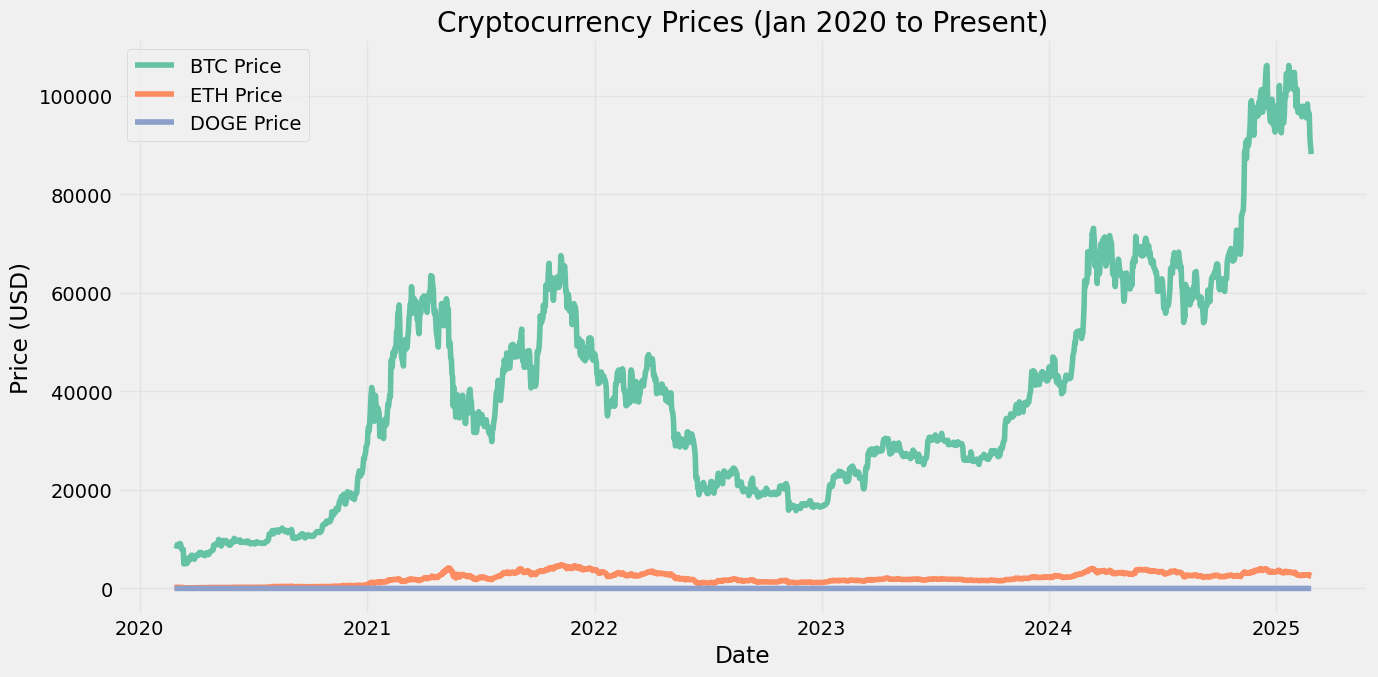

In [14]:
# Visualize Daily Closing Prices
# ====================================
plt.figure(figsize=(14, 7))

for crypto_name, data in crypto_daily_data.items():
    plt.plot(data.index, data['close'], label=f"{crypto_name} Price")

plt.title('Cryptocurrency Prices (Jan 2020 to Present)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

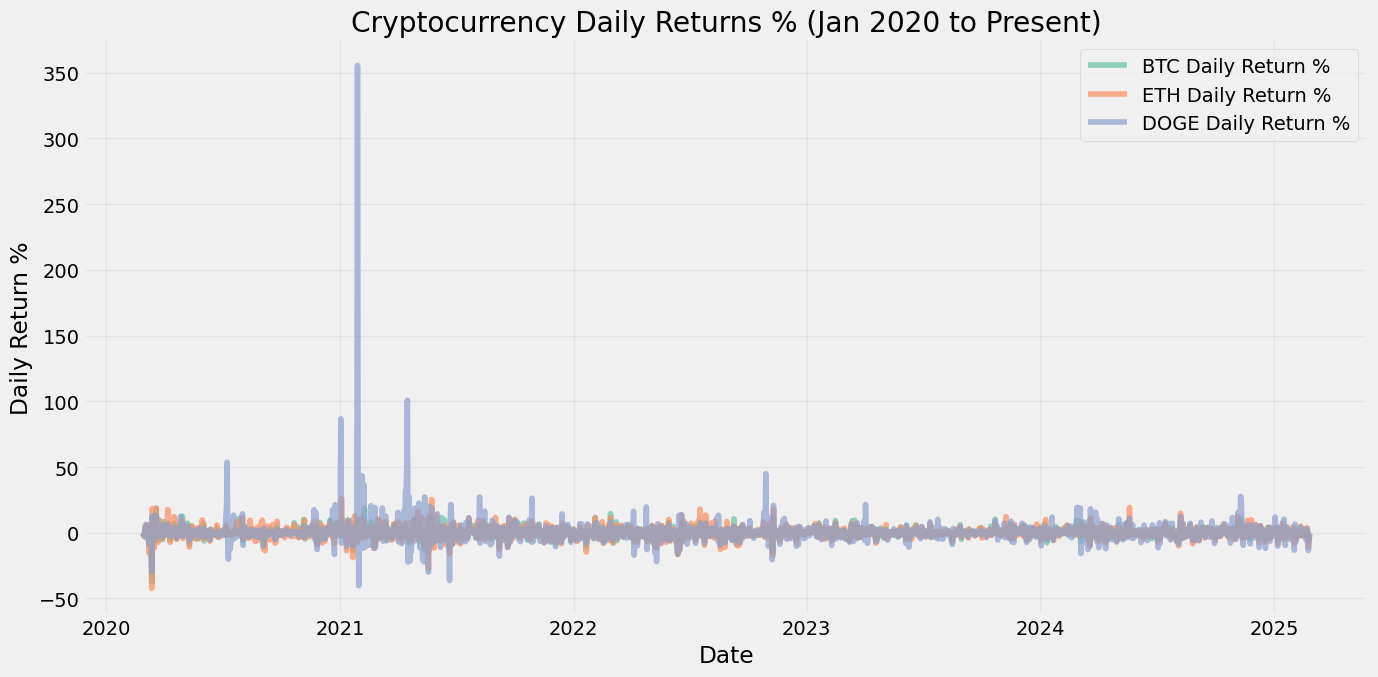

In [15]:
# Visualize Daily Returns
# =============================
plt.figure(figsize=(14, 7))

for crypto_name, data in crypto_daily_data.items():
    plt.plot(data.index, data['daily_return'], label=f"{crypto_name} Daily Return %", alpha=0.7)

plt.title('Cryptocurrency Daily Returns % (Jan 2020 to Present)')
plt.xlabel('Date')
plt.ylabel('Daily Return %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

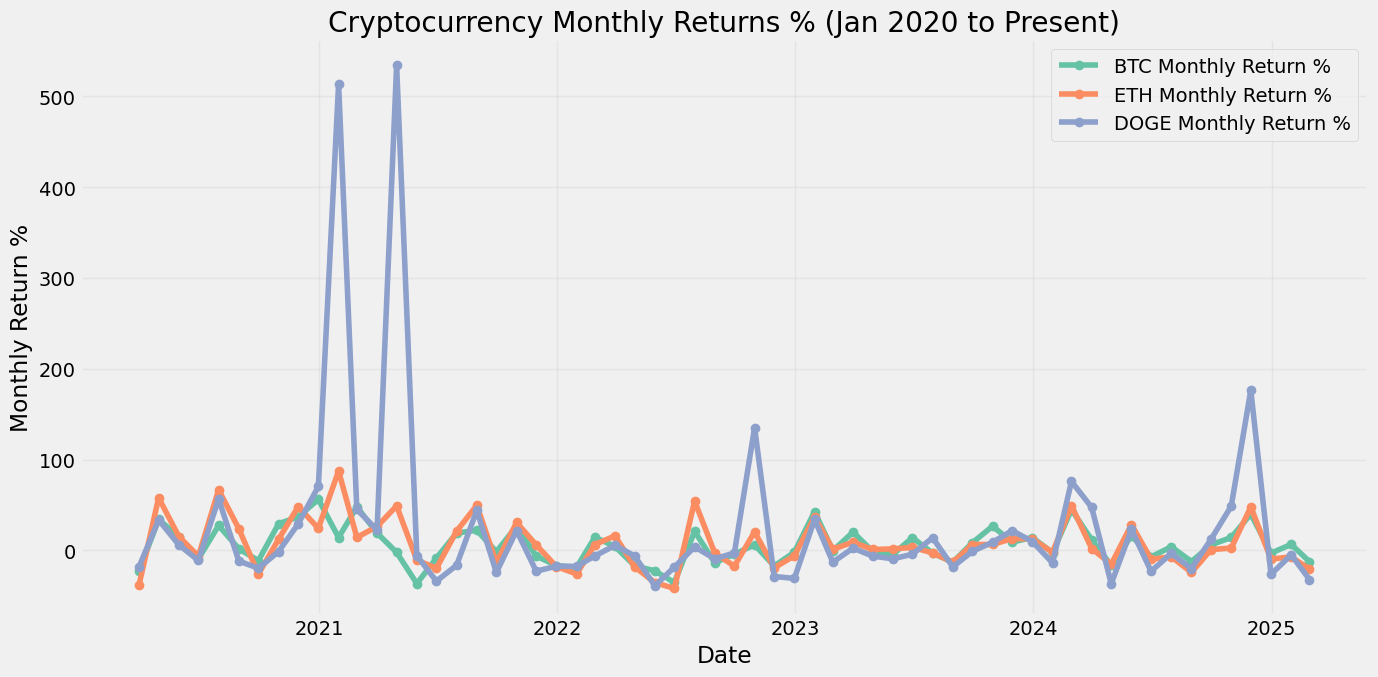

In [16]:
# Visualize Monthly Returns
# ===============================
plt.figure(figsize=(14, 7))

for crypto_name, data in crypto_monthly_data.items():
    plt.plot(data.index, data['monthly_return'], label=f"{crypto_name} Monthly Return %", marker='o')

plt.title('Cryptocurrency Monthly Returns % (Jan 2020 to Present)')
plt.xlabel('Date')
plt.ylabel('Monthly Return %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Calculate Return Statistics
# ==================================
# Create a DataFrame to store statistics
stats_daily = pd.DataFrame(index=crypto_daily_data.keys())
stats_monthly = pd.DataFrame(index=crypto_monthly_data.keys())

# Calculate statistics for daily returns
for crypto_name, data in crypto_daily_data.items():
    returns = data['daily_return'].dropna()
    stats_daily.loc[crypto_name, 'Mean Daily Return %'] = returns.mean()
    stats_daily.loc[crypto_name, 'Median Daily Return %'] = returns.median()
    stats_daily.loc[crypto_name, 'Std Dev Daily Return %'] = returns.std()
    stats_daily.loc[crypto_name, 'Min Daily Return %'] = returns.min()
    stats_daily.loc[crypto_name, 'Max Daily Return %'] = returns.max()
    stats_daily.loc[crypto_name, 'Positive Days %'] = (returns > 0).mean() * 100
    stats_daily.loc[crypto_name, 'Negative Days %'] = (returns < 0).mean() * 100

# Calculate statistics for monthly returns
for crypto_name, data in crypto_monthly_data.items():
    returns = data['monthly_return'].dropna()
    stats_monthly.loc[crypto_name, 'Mean Monthly Return %'] = returns.mean()
    stats_monthly.loc[crypto_name, 'Median Monthly Return %'] = returns.median()
    stats_monthly.loc[crypto_name, 'Std Dev Monthly Return %'] = returns.std()
    stats_monthly.loc[crypto_name, 'Min Monthly Return %'] = returns.min()
    stats_monthly.loc[crypto_name, 'Max Monthly Return %'] = returns.max()
    stats_monthly.loc[crypto_name, 'Positive Months %'] = (returns > 0).mean() * 100
    stats_monthly.loc[crypto_name, 'Negative Months %'] = (returns < 0).mean() * 100

# Display statistics
print("\nDaily Return Statistics:")
display(stats_daily)

print("\nMonthly Return Statistics:")
display(stats_monthly)


Daily Return Statistics:


,Mean Daily Return %,Median Daily Return %,Std Dev Daily Return %,Min Daily Return %,Max Daily Return %,Positive Days %,Negative Days %
BTC,0.183003,0.061781,3.340370,-37.169539,18.746474,51.040526,48.959474
ETH,0.226120,0.140531,4.313527,-42.347221,25.947533,52.135816,47.864184
DOGE,0.576711,-0.024420,10.858880,-40.256986,355.546631,49.561884,50.164294



Monthly Return Statistics:


,Mean Monthly Return %,Median Monthly Return %,Std Dev Monthly Return %,Min Monthly Return %,Max Monthly Return %,Positive Months %,Negative Months %
BTC,5.895762,4.165464,20.419095,-36.562057,56.220579,53.333333,46.666667
ETH,7.377694,2.304112,27.275069,-41.884999,87.445420,58.333333,41.666667
DOGE,24.052516,-3.811562,101.225616,-38.951443,533.993187,43.333333,56.666667


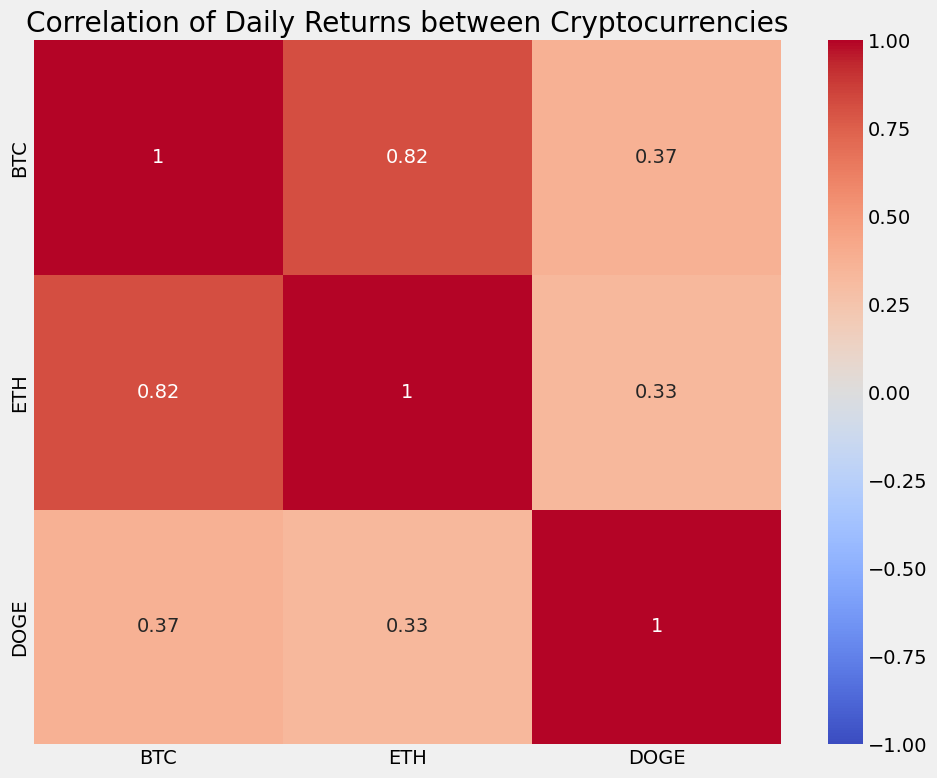

In [18]:
# Correlation Analysis
# ===========================
# Create a DataFrame with daily returns for all cryptocurrencies
combined_returns = pd.DataFrame()

for crypto_name, data in crypto_daily_data.items():
    combined_returns[crypto_name] = data['daily_return']

# Calculate correlation matrix
correlation_matrix = combined_returns.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation of Daily Returns between Cryptocurrencies')
plt.tight_layout()
plt.show()

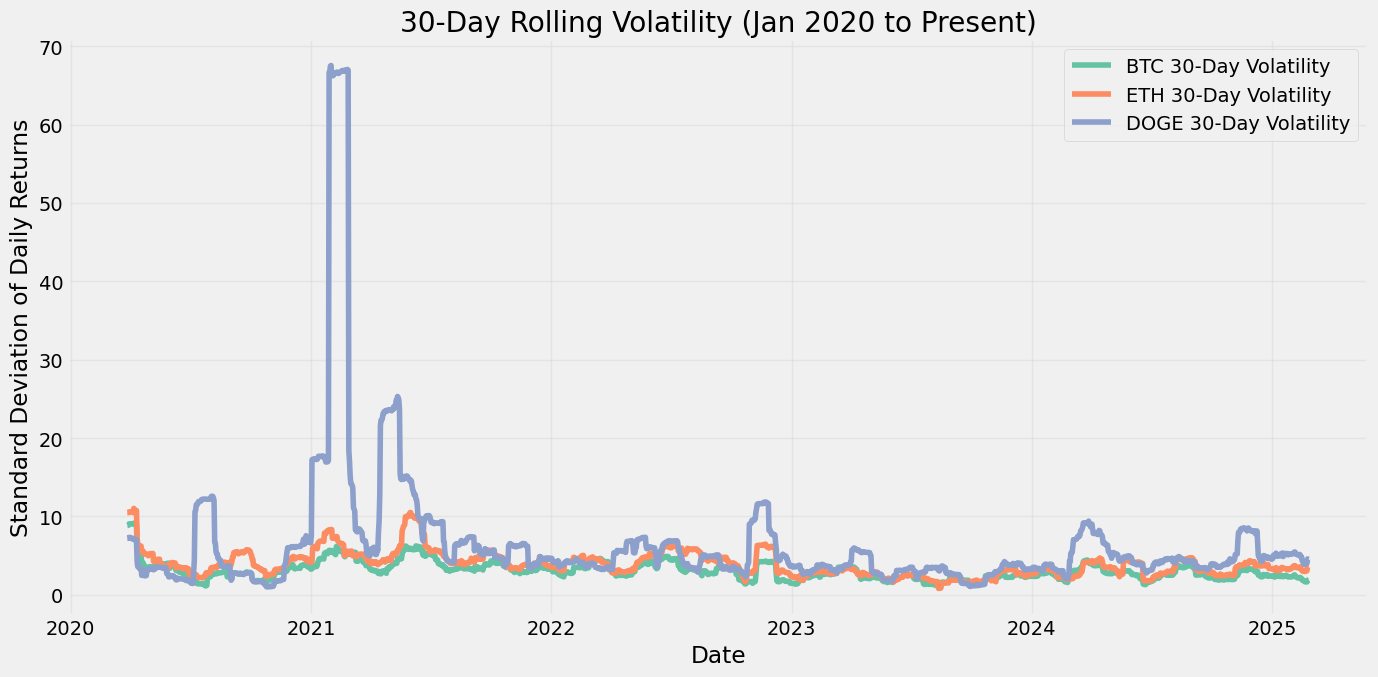

In [19]:
#Rolling Volatility (30-day window)
# =========================================
plt.figure(figsize=(14, 7))

for crypto_name, data in crypto_daily_data.items():
    # Calculate 30-day rolling standard deviation (volatility)
    rolling_vol = data['daily_return'].rolling(window=30).std()
    plt.plot(rolling_vol.index, rolling_vol, label=f"{crypto_name} 30-Day Volatility")

plt.title('30-Day Rolling Volatility (Jan 2020 to Present)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation of Daily Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

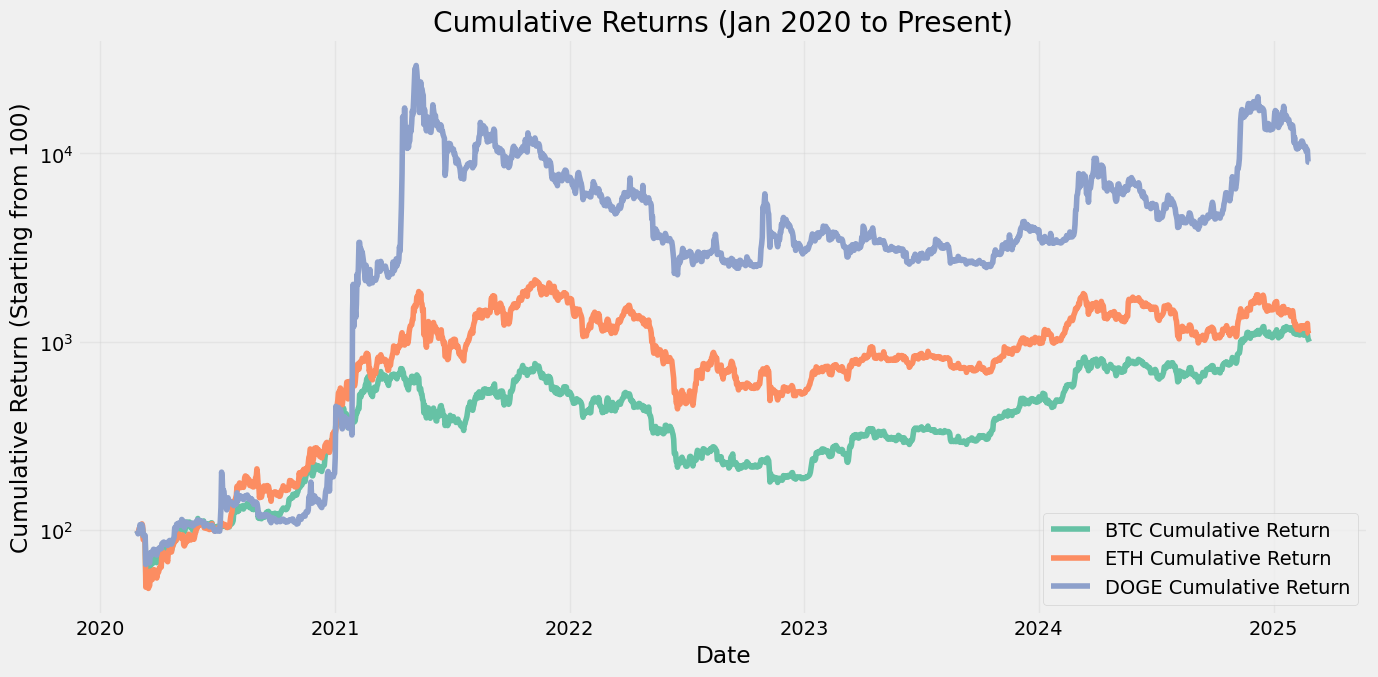

In [20]:
# Calculate Cumulative Returns
# ===================================
plt.figure(figsize=(14, 7))

for crypto_name, data in crypto_daily_data.items():
    # Calculate cumulative returns (starting from 100)
    daily_returns_decimal = data['daily_return'] / 100  # Convert percentage to decimal
    cumulative_returns = (1 + daily_returns_decimal).cumprod() * 100
    plt.plot(cumulative_returns.index, cumulative_returns, label=f"{crypto_name} Cumulative Return")

plt.title('Cumulative Returns (Jan 2020 to Present)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Starting from 100)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Using log scale to better visualize differences
plt.tight_layout()
plt.show()

In [24]:
# Upload CSV files to Amazon S3
def upload_to_s3(file_path, bucket_name, s3_key=None):
    """
    Upload a file to an S3 bucket
    
    Parameters:
    - file_path: Path to the file to upload
    - bucket_name: Name of the S3 bucket
    - s3_key: S3 object key. If not specified, the filename will be used
    
    Returns:
    - True if file was uploaded, False otherwise
    """
    # If S3 key is not specified, use the filename
    if s3_key is None:
        s3_key = os.path.basename(file_path)
    aws_credentials_str = Secret.get("CRYPTO_AWS_CREDENTIALS")

    # Parse the JSON string into a dictionary
    aws_credentials = json.loads(aws_credentials_str)

# Create the S3 client using the credentials from the secret
    s3_client = boto3.client(
        's3',
        aws_access_key_id=aws_credentials["ACCESS_KEY_ID"],
        aws_secret_access_key=aws_credentials["SECRET_ACCESS_KEY"],
        region_name=aws_credentials["REGION"]
    )
    
    try:
        print(f"Uploading {file_path} to s3://{bucket_name}/{s3_key}...")
        s3_client.upload_file(file_path, bucket_name, s3_key)
        print(f"Successfully uploaded {file_path} to S3")
        return True
    except ClientError as e:
        print(f"Error uploading {file_path} to S3: {e}")
        return False

# S3 bucket name
S3_BUCKET_NAME = "damg7245-crypto"  # Replace with your actual bucket name
S3_PREFIX = "raw_data"  # Optional prefix for organizing files in S3

# Get all CSV files in the data directory
csv_files = [os.path.join("data", f) for f in os.listdir("data") if f.endswith('.csv')]

# Upload each CSV file to S3
for csv_file in csv_files:
    # Create S3 key with optional prefix
    file_name = os.path.basename(csv_file)
    s3_key = f"{S3_PREFIX}/{file_name}" if S3_PREFIX else file_name
    
    # Upload file
    upload_to_s3(csv_file, S3_BUCKET_NAME, s3_key)

# Optionally upload the Excel file if it exists

print("\nS3 upload complete!")

Uploading data/ETH_raw_monthly.csv to s3://damg7245-crypto/raw_data/ETH_raw_monthly.csv...
Successfully uploaded data/ETH_raw_monthly.csv to S3
Uploading data/DOGE_direct_monthly_returns.csv to s3://damg7245-crypto/raw_data/DOGE_direct_monthly_returns.csv...
Successfully uploaded data/DOGE_direct_monthly_returns.csv to S3
Uploading data/ETH_direct_monthly_returns.csv to s3://damg7245-crypto/raw_data/ETH_direct_monthly_returns.csv...
Successfully uploaded data/ETH_direct_monthly_returns.csv to S3
Uploading data/ETH_raw_daily.csv to s3://damg7245-crypto/raw_data/ETH_raw_daily.csv...
Successfully uploaded data/ETH_raw_daily.csv to S3
Uploading data/BTC_monthly_returns.csv to s3://damg7245-crypto/raw_data/BTC_monthly_returns.csv...
Successfully uploaded data/BTC_monthly_returns.csv to S3
Uploading data/BTC_daily_returns.csv to s3://damg7245-crypto/raw_data/BTC_daily_returns.csv...
Successfully uploaded data/BTC_daily_returns.csv to S3
Uploading data/BTC_raw_daily.csv to s3://damg7245-crypt